# Import

In [1]:
from gemseo_oad_training.models import aerodynamic
from gemseo_oad_training.models import approach
from gemseo_oad_training.models import battery
from gemseo_oad_training.models import climb
from gemseo_oad_training.models import engine
from gemseo_oad_training.models import fuel_tank
from gemseo_oad_training.models import geometry
from gemseo_oad_training.models import mass
from gemseo_oad_training.models import mission
from gemseo_oad_training.models import operating_cost
from gemseo_oad_training.models import take_off
from gemseo_oad_training.models import total_mass
from gemseo import configure_logger
from gemseo.disciplines.auto_py import AutoPyDiscipline
from gemseo.algos.parameter_space import ParameterSpace
from gemseo import from_pickle
from lh2pac.utils import update_default_inputs
from gemseo.algos.design_space import DesignSpace
from gemseo_oad_training.unit import convert_from
from gemseo_umdo.scenarios.umdo_scenario import UMDOScenario
from gemseo_umdo.formulations.sampling_settings import Sampling_Settings
from gemseo_oad_training.utils import draw_aircraft
from gemseo_oad_training.utils import AircraftConfiguration


configure_logger()

<RootLogger root (INFO)>

# Instanciate disciplines

In [2]:
# On veut résoudre le problème 1 avec UC1 et UC2
disciplines = [AutoPyDiscipline(aerodynamic), AutoPyDiscipline(approach), AutoPyDiscipline(battery), AutoPyDiscipline(climb), AutoPyDiscipline(engine), AutoPyDiscipline(fuel_tank), AutoPyDiscipline(geometry), AutoPyDiscipline(mass), AutoPyDiscipline(mission), AutoPyDiscipline(operating_cost), AutoPyDiscipline(take_off), AutoPyDiscipline(total_mass)]

In [3]:
update_default_inputs(disciplines, {"fuel_type": "liquid_h2"})
disciplines[5].io.input_grammar.defaults

{'fuel_type': 'liquid_h2', 'gi': 0.4, 'tkv': 20.0}

# Create design space for the original disciplines

In [4]:
# Create the design space
design_space = DesignSpace()
design_space.add_variable('slst', lower_bound=100000.0, upper_bound=200000.0, value=150000.0)
design_space.add_variable('n_pax', lower_bound=120, upper_bound=180, value=150)
design_space.add_variable('area', lower_bound=100, upper_bound=200, value=180)
design_space.add_variable('ar', lower_bound=5, upper_bound=20, value=9)

# Create uncertain space

In [5]:
uncertain_space = ParameterSpace()

uncertain_space.add_random_variable("aef", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)
uncertain_space.add_random_variable("cef", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)
uncertain_space.add_random_variable("sef", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)
uncertain_space.add_random_variable("gi", "OTTriangularDistribution", minimum=0.35, mode=0.4, maximum=0.405)
uncertain_space.add_random_variable("vi", "OTTriangularDistribution", minimum=0.755, mode=0.800, maximum=0.805)

# Add constraints

In [6]:
scenario = UMDOScenario(
    disciplines,
    "mtom",
    design_space,
    uncertain_space,
    objective_statistic_name="Mean",
    formulation_name="MDF",
    statistic_estimation_settings=Sampling_Settings(
        n_samples=100, estimate_statistics_iteratively=False
    ),
)

In [7]:
# Add the constraints
scenario.add_constraint('tofl', constraint_type='ineq', value=1900.0, positive=False, statistic_name="Margin", factor=2.0)
scenario.add_constraint('vapp', constraint_type='ineq', value=convert_from("kt",135.0), positive=False, statistic_name="Margin", factor=2.0)
scenario.add_constraint('vz', constraint_type='ineq', value=convert_from("ft/min",300.0), positive=True, statistic_name="Margin", factor=-2.0)
scenario.add_constraint('span', constraint_type='ineq', value=40.0, positive=False, statistic_name="Margin", factor=2.0)
scenario.add_constraint('length', constraint_type='ineq', value=45.0, positive=False, statistic_name="Margin", factor=2.0)
scenario.add_constraint('fm', constraint_type='ineq', value=0.0, positive=True, statistic_name="Margin", factor=-2.0)

# Execute scenario

In [8]:
scenario.execute(algo_name="NLOPT_COBYLA", max_iter=1)

    INFO - 10:52:28: *** Start UMDOScenario execution ***
    INFO - 10:52:28: UMDOScenario
    INFO - 10:52:28:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 10:52:28:    Formulation:
    INFO - 10:52:28:       MDO formulation: MDF
    INFO - 10:52:28:       Statistic estimation: Sampling
    INFO - 10:52:28:    Uncertain space:
    INFO - 10:52:28:       +------+------------------------------------------------+
    INFO - 10:52:28:       | Name |                  Distribution                  |
    INFO - 10:52:28:       +------+------------------------------------------------+
    INFO - 10:52:28:       | aef  |   Triangular(lower=0.99, mode=1, upper=1.03)   |
    INFO - 10:52:28:       | cef  |   Triangular(lower=0.99, mode=1, upper=1.03)   |
    INFO - 10:52:28:       | sef  |   Triangular(lower=0.99, mode=1, upper=1.03)   |
    INFO - 10:52:28:       |  gi  | Triangular(lower=0.35, mode=0.4,

 WARNING - 10:52:29: Optimization found no feasible point; the least infeasible point is selected.
 WARNING - 10:52:29: Optimization found no feasible point; the least infeasible point is selected.


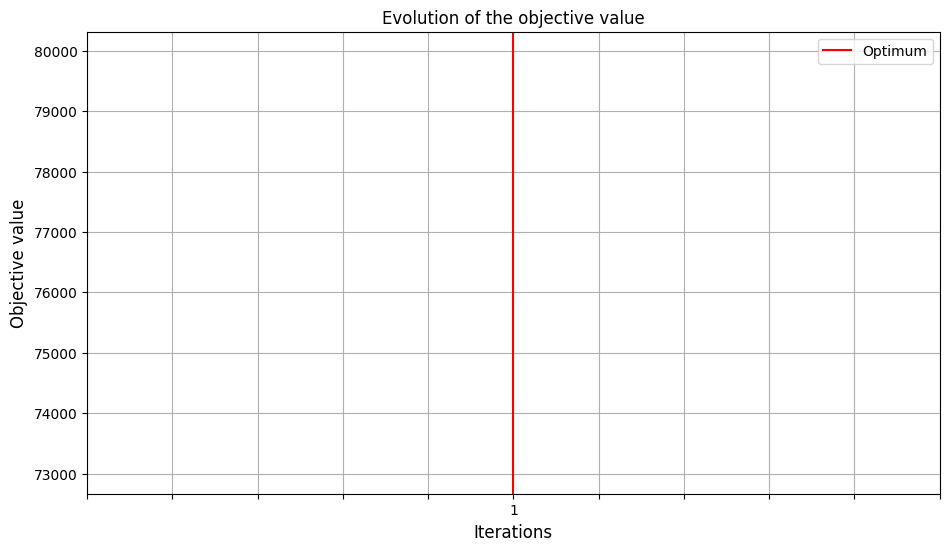

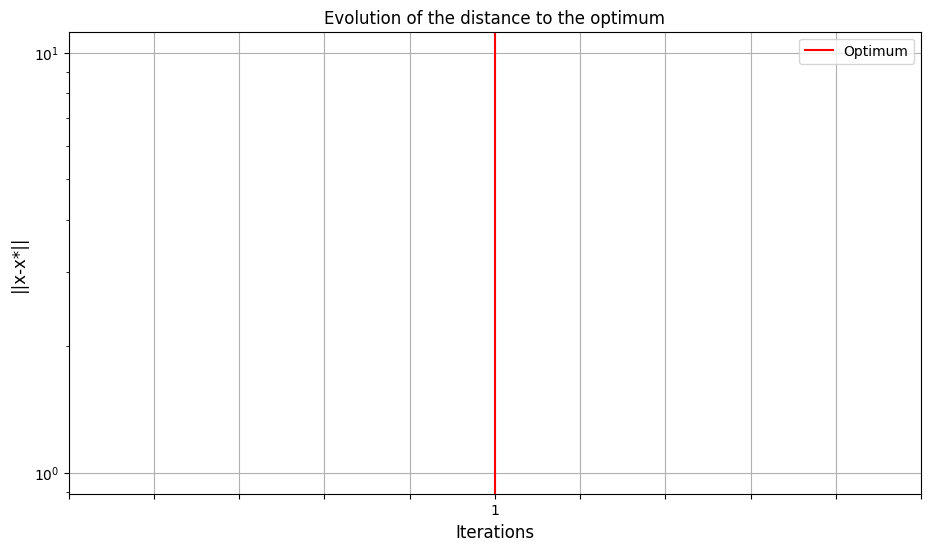

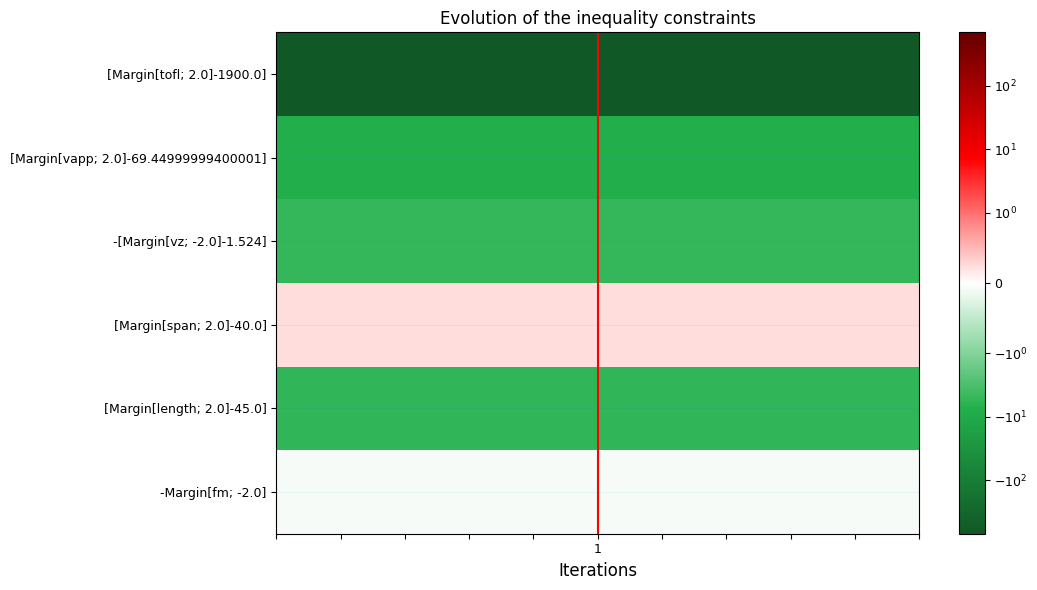

In [9]:
scenario.post_process(post_name="OptHistoryView", save=False, show=True)

In [10]:
result = scenario.optimization_result
(result.x_opt, result.constraint_values, result.f_opt)

(array([1.5e+05, 1.5e+02, 1.8e+02, 9.0e+00]),
 {'[Margin[tofl; 2.0]-1900.0]': array([-699.07825869]),
  '[Margin[vapp; 2.0]-69.44999999400001]': array([-8.1537286]),
  '-[Margin[vz; -2.0]-1.524]': array([-4.92442407]),
  '[Margin[span; 2.0]-40.0]': array([0.24922359]),
  '[Margin[length; 2.0]-45.0]': array([-5.25]),
  '-Margin[fm; -2.0]': array([-0.06158628])},
 76490.27890804182)

# Import surrogate model

In [11]:
surrogate_disciplines = from_pickle("UC2_my_surrogate_3.pkl")
surrogate_disciplines

Surrogate discipline: RBF_Sampling
   Dataset name: Sampling
   Dataset size: 28
   Surrogate model: RBFRegressor
   Inputs: aef, ar, area, cef, n_pax, sef, slst
   Outputs: fm, length, mtom, span, tofl, vapp, vz
   Linearization mode: auto

# Create a new design space


In [12]:
design_space_surrogate = DesignSpace()
design_space_surrogate.add_variable('slst', lower_bound=100000.0, upper_bound=200000.0, value=150000.0)
design_space_surrogate.add_variable('n_pax', lower_bound=120, upper_bound=180, value=150)
design_space_surrogate.add_variable('area', lower_bound=100, upper_bound=200, value=180)
design_space_surrogate.add_variable('ar', lower_bound=5, upper_bound=20, value=9)

In [13]:
uncertain_space_surrogate = ParameterSpace()
uncertain_space_surrogate.add_random_variable("aef", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)
uncertain_space_surrogate.add_random_variable("cef", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)
uncertain_space_surrogate.add_random_variable("sef", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)
uncertain_space_surrogate.add_random_variable("gi", "OTTriangularDistribution", minimum=0.35, mode=0.4, maximum=0.405)
uncertain_space_surrogate.add_random_variable("vi", "OTTriangularDistribution", minimum=0.755, mode=0.800, maximum=0.805)

In [14]:
scenario_surrogate = UMDOScenario(
    [surrogate_disciplines],
    "mtom",
    design_space_surrogate,
    uncertain_space_surrogate,
    objective_statistic_name="Mean",
    formulation_name="MDF",
    statistic_estimation_settings=Sampling_Settings(
        n_samples=100, estimate_statistics_iteratively=False
    ),
)

 WARNING - 13:48:00: No coupling in MDA, switching chain_linearize to True.
 WARNING - 13:48:00: No coupling in MDA, switching chain_linearize to True.
    INFO - 13:48:00: Variable gi was removed from the Design Space, it is not an input of any discipline.
    INFO - 13:48:00: Variable vi was removed from the Design Space, it is not an input of any discipline.


In [15]:
# Add the constraints
scenario_surrogate.add_constraint('tofl', constraint_type='ineq', value=1900.0, positive=False, statistic_name="Margin", factor=2.0)
scenario_surrogate.add_constraint('vapp', constraint_type='ineq', value=convert_from("kt",135.0), positive=False, statistic_name="Margin", factor=2.0)
scenario_surrogate.add_constraint('vz', constraint_type='ineq', value=convert_from("ft/min",300.0), positive=True, statistic_name="Margin", factor=-2.0)
scenario_surrogate.add_constraint('span', constraint_type='ineq', value=40.0, positive=False, statistic_name="Margin", factor=2.0)
scenario_surrogate.add_constraint('length', constraint_type='ineq', value=45.0, positive=False, statistic_name="Margin", factor=2.0)
scenario_surrogate.add_constraint('fm', constraint_type='ineq', value=0.0, positive=True, statistic_name="Margin", factor=-2.0)

In [16]:
scenario_surrogate.execute(algo_name="NLOPT_COBYLA", max_iter=100)

    INFO - 13:48:00: *** Start UMDOScenario execution ***
    INFO - 13:48:00: UMDOScenario
    INFO - 13:48:00:    Disciplines: RBF_Sampling
    INFO - 13:48:00:    Formulation:
    INFO - 13:48:00:       MDO formulation: MDF
    INFO - 13:48:00:       Statistic estimation: Sampling
    INFO - 13:48:00:    Uncertain space:
    INFO - 13:48:00:       +------+--------------------------------------------+
    INFO - 13:48:00:       | Name |                Distribution                |
    INFO - 13:48:00:       +------+--------------------------------------------+
    INFO - 13:48:00:       | aef  | Triangular(lower=0.99, mode=1, upper=1.03) |
    INFO - 13:48:00:       | cef  | Triangular(lower=0.99, mode=1, upper=1.03) |
    INFO - 13:48:00:       | sef  | Triangular(lower=0.99, mode=1, upper=1.03) |
    INFO - 13:48:00:       +------+--------------------------------------------+
    INFO - 13:48:00: Optimization problem:
    INFO - 13:48:00:    minimize E[mtom]
    INFO - 13:48:00:   

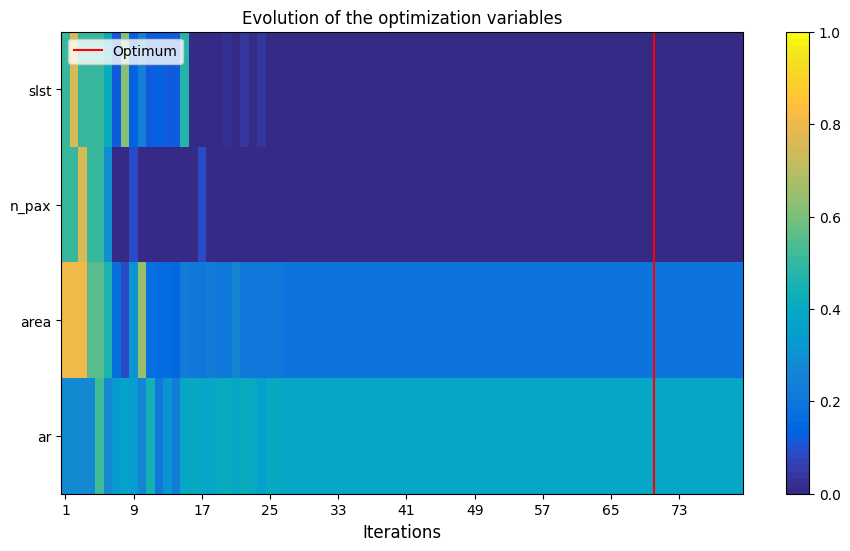

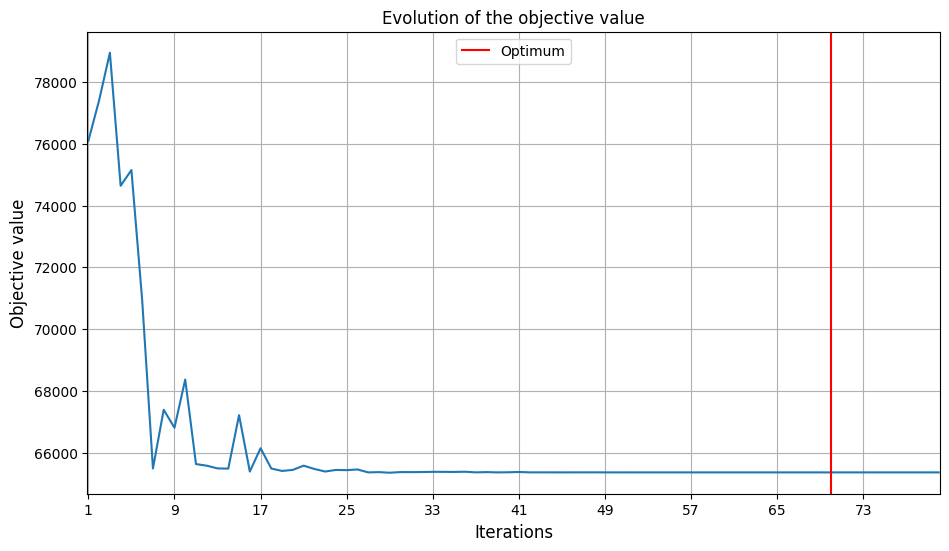

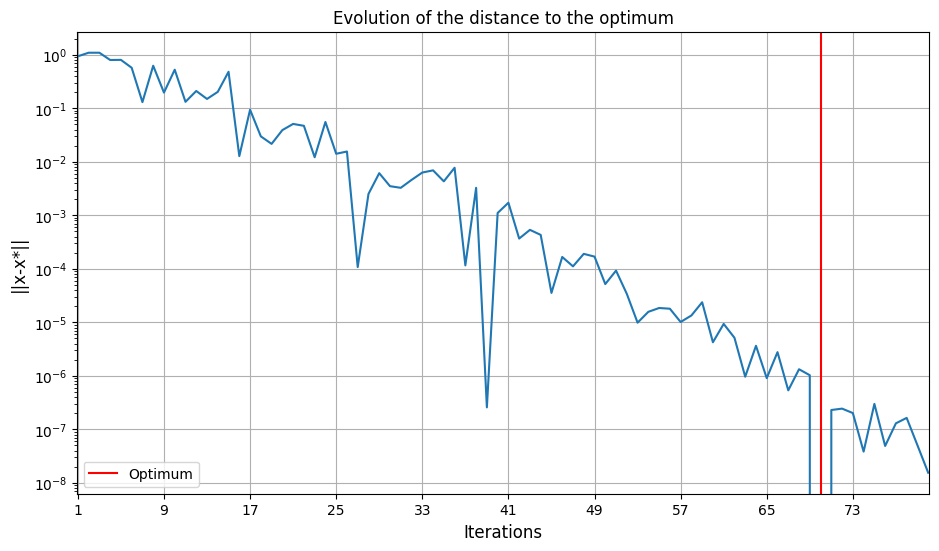

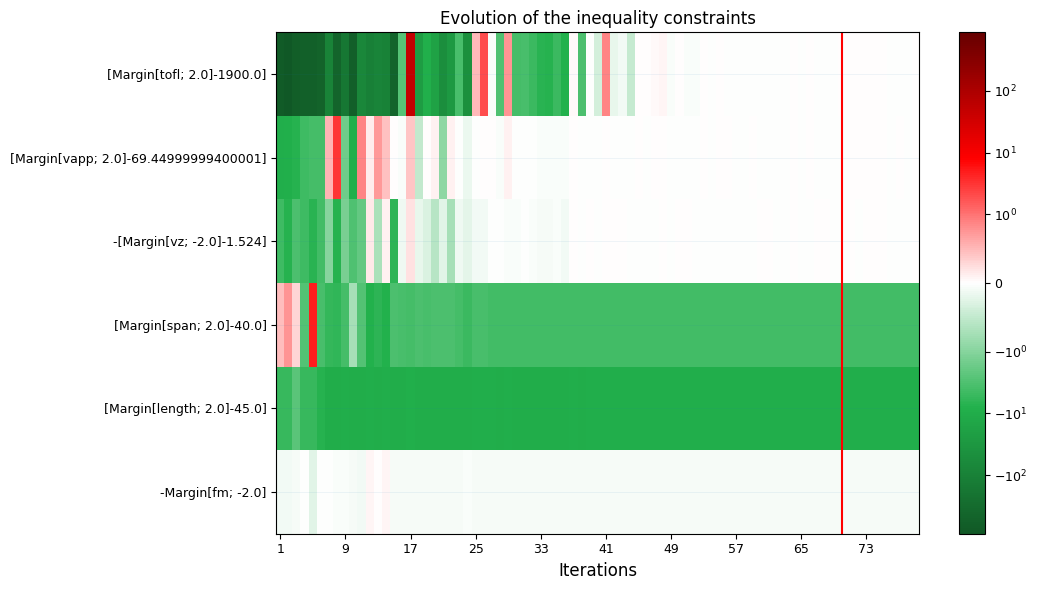

In [17]:
scenario_surrogate.post_process(post_name="OptHistoryView", save=False, show=True)

# Evaluate surrogate optimum in the original model

## Compare results

In [18]:
scenario.optimization_result.x_opt_as_dict

{'slst': array([101202.59098526]),
 'n_pax': array([120.]),
 'area': array([115.77575615]),
 'ar': array([9.51190118])}

## Evaluate optimum

In [19]:
scenario_surrogate.optimization_result.x_opt_as_dict

{'slst': array([100094.7415271]),
 'n_pax': array([120.]),
 'area': array([120.07180207]),
 'ar': array([10.69330667])}

In [20]:
scenario_test = UMDOScenario(
    disciplines,
    "mtom",
    design_space,
    uncertain_space,
    objective_statistic_name="Mean",
    formulation_name="MDF",
    statistic_estimation_settings=Sampling_Settings(
        n_samples=100, estimate_statistics_iteratively=False
    ),
)

In [21]:
# Add the constraints
scenario_test.add_constraint('tofl', constraint_type='ineq', value=1900.0, positive=False, statistic_name="Margin", factor=2.0)
scenario_test.add_constraint('vapp', constraint_type='ineq', value=convert_from("kt",135.0), positive=False, statistic_name="Margin", factor=2.0)
scenario_test.add_constraint('vz', constraint_type='ineq', value=convert_from("ft/min",300.0), positive=True, statistic_name="Margin", factor=-2.0)
scenario_test.add_constraint('span', constraint_type='ineq', value=40.0, positive=False, statistic_name="Margin", factor=2.0)
scenario_test.add_constraint('length', constraint_type='ineq', value=45.0, positive=False, statistic_name="Margin", factor=2.0)
scenario_test.add_constraint('fm', constraint_type='ineq', value=0.0, positive=True, statistic_name="Margin", factor=-2.0)

In [22]:
scenario_test.execute(algo_name = 'CustomDOE', samples = [scenario_surrogate.optimization_result.x_opt_as_dict])

    INFO - 13:48:53: *** Start UMDOScenario execution ***
    INFO - 13:48:53: UMDOScenario
    INFO - 13:48:53:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 13:48:53:    Formulation:
    INFO - 13:48:53:       MDO formulation: MDF
    INFO - 13:48:53:       Statistic estimation: Sampling
    INFO - 13:48:53:    Uncertain space:
    INFO - 13:48:53:       +------+------------------------------------------------+
    INFO - 13:48:53:       | Name |                  Distribution                  |
    INFO - 13:48:53:       +------+------------------------------------------------+
    INFO - 13:48:53:       | aef  |   Triangular(lower=0.99, mode=1, upper=1.03)   |
    INFO - 13:48:53:       | cef  |   Triangular(lower=0.99, mode=1, upper=1.03)   |
    INFO - 13:48:53:       | sef  |   Triangular(lower=0.99, mode=1, upper=1.03)   |
    INFO - 13:48:53:       |  gi  | Triangular(lower=0.35, mode=0.4,

# Draw aircrafts

In [39]:
constraint_values = scenario.optimization_result.constraint_values
constraint_values_surrogate = scenario_surrogate.optimization_result.constraint_values

print("Constraints values for the original scenario:")
for name, value in constraint_values.items():
    print(f"{name}: {value}")
print("\nConstraints values for the surrogate scenario:")
for name, value in constraint_values_surrogate.items():
    print(f"{name}: {value}")

Constraints values for the original scenario:
[Margin[tofl; 2.0]-1900.0]: [4.71404292e-07]
[Margin[vapp; 2.0]-69.44999999400001]: [4.25715996e-09]
-[Margin[vz; -2.0]-1.524]: [-0.2304578]
[Margin[span; 2.0]-40.0]: [-6.81494988]
[Margin[length; 2.0]-45.0]: [-10.25]
-Margin[fm; -2.0]: [9.25338833e-11]

Constraints values for the surrogate scenario:
[Margin[tofl; 2.0]-1900.0]: [1.18234311e-11]
[Margin[vapp; 2.0]-69.44999999400001]: [-2.98427949e-13]
-[Margin[vz; -2.0]-1.524]: [-1.16040511e-12]
[Margin[span; 2.0]-40.0]: [-4.03186579]
[Margin[length; 2.0]-45.0]: [-9.57731003]
-Margin[fm; -2.0]: [-0.05844353]


In [46]:
AC1 =AircraftConfiguration(name = 'Optimal', length= 24.5, span = 26.37, area = 115.77575615, color = 'blue')
AC2 =AircraftConfiguration(name = 'Surrogate', length= 24.5, span = 31.66490358, area = 120.07180207, color = 'orange')

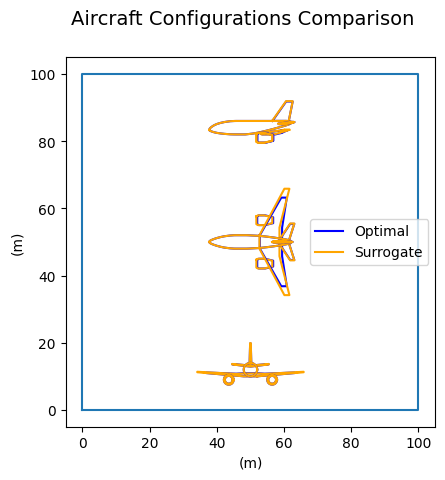

In [47]:
draw_aircraft(AC1, AC2, title="Aircraft Configurations Comparison", save=False, show=True)